# Aperiodic electrophysiological activity tracks spiking statistics between behavioral states
Sawyer Figueroa, Michael Preston, Bradley Voytek

# SfN 2023, Poster Panel 4
This notebook reproduces the figures from poster panel 4. Panel 4 investigates the relationship between spike-synchrony and aperiodic LFP activity. Comparisons are made between behavioral epochs.

Dataset: Allen Institute for Brain Science: Visual Coding - Neuropixels  
© 2015 Allen Institute for Brain Science. Allen Brain Atlas API. Available from: https://portal.brain-map.org/explore/circuits/visual-coding-neuropixels

## Set-up

### set paths

In [1]:
# set paths
PROJECT_PATH = "G:/Shared drives/visual_encoding" # shared results directory
MANIFEST_PATH = 'D:/datasets/allen_vc' # path to manifest file and local dataset

### imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as sts
import statsmodels.api as sm
import os

In [5]:
# custom imports
import sys
sys.path.append('../../')
from allen_vc.plots import scatter_2_conditions
from allen_vc.utils import combine_spike_lfp_dfs, channel_medians

print("Imported!")

Imported!


### settings

In [6]:
# matplotlib and figure appearance settings
plt.style.use(f'../../stylelib/sfn_2023.mplstyle')
# COLORS = ["#7570b3", "#3FAA96", "#F39943"]

### load data

In [8]:
movie_spikes = pd.read_csv(f'{PROJECT_PATH}/data/spike_data/synchrony_data/VISp-LGd_natural_movie.csv')
movie_lfp = pd.read_csv(f'{PROJECT_PATH}/data/lfp_data/params/psd/natural_movie_one_more_repeats/lfp_params.csv')

In [11]:
shuffled_spikes = pd.read_csv(f'{PROJECT_PATH}/data/spike_data/synchrony_data/VISp-LGd_natural_movie_shuffled.csv')
shuffled_lfp = pd.read_csv(f'{PROJECT_PATH}/data/lfp_data/params/psd/natural_movie_one_more_repeats/lfp_params.csv')

## Main

#### All session mean firing rate vs. broadband offset 

C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


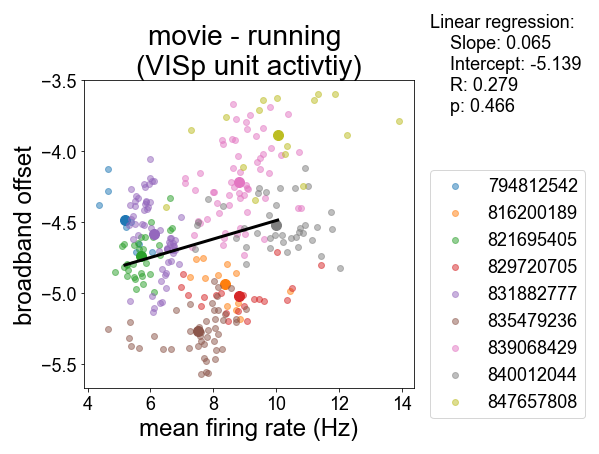

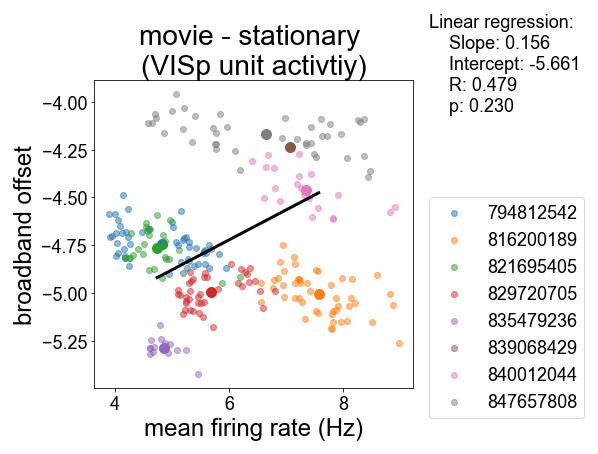

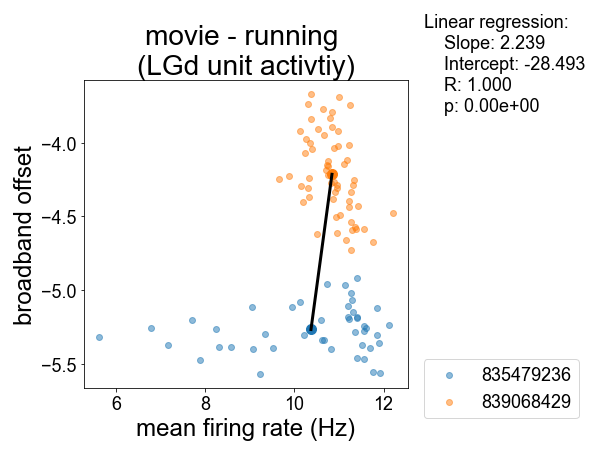

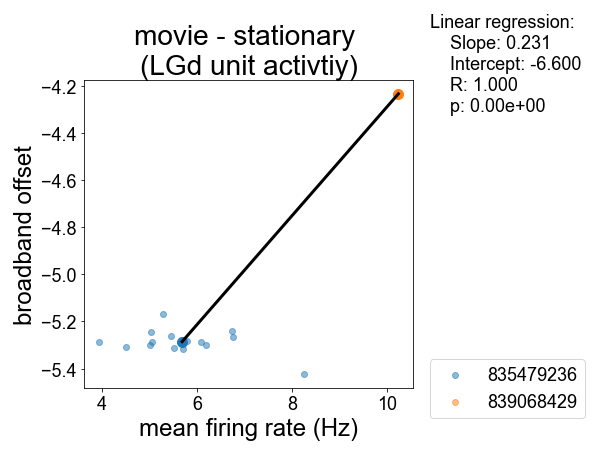

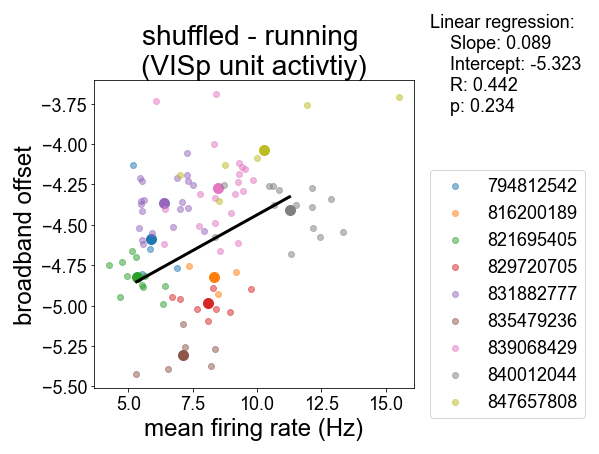

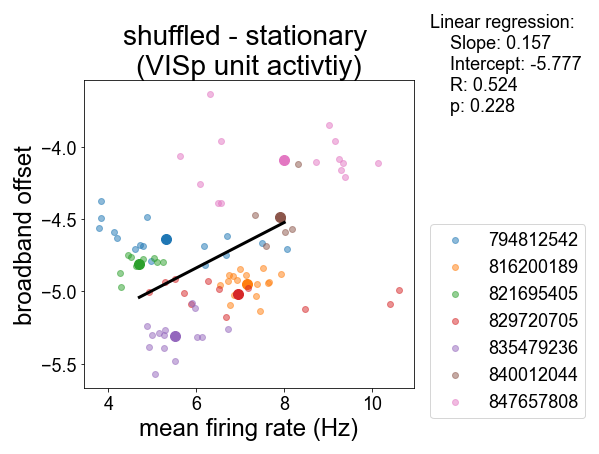

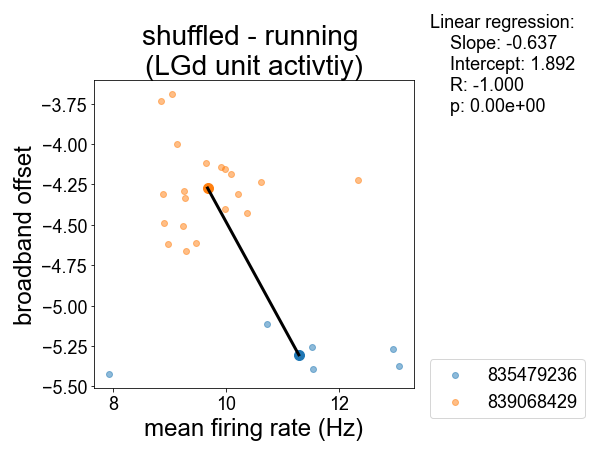

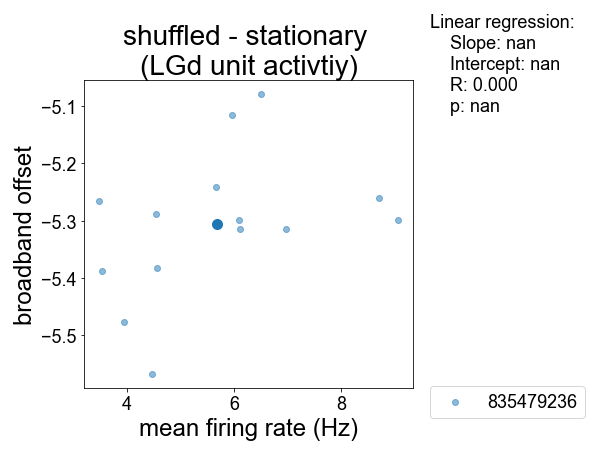

In [12]:
# loop through stimuli
for stimulus, df_lfp, df_units in zip(['movie', 'shuffled'], 
                                      [movie_lfp, shuffled_lfp],
                                      [movie_spikes, shuffled_spikes]):
    # modify df_lfp - average over channels for each epoch within each session
    df_lfp_i = df_lfp.groupby(['session', 'epoch_idx']).mean().reset_index()

    # loop through spiking region
    for spike_region in ['VISp', 'LGd']:
        # get unit data for this region
        df_units_i = df_units[df_units.get("brain_structure")==spike_region]  

        # merge unit and lfp dataframes
        df_i = df_lfp_i.merge(df_units_i, on=['session', 'epoch_idx'])

        # loop through behavioral conditions
        for behavior, running in zip(['running', 'stationary'], [True, False]):

            # filter df by behavior
            df = df_i[df_i.get('running')==running]
            
            # plot each session
            sessions = df.get('session').unique()
            fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
            fig.patch.set_facecolor('white')
            for ses in sessions:
                ses_df = df[df.get('session')==ses]

                # plot each epoch
                sc =  ax.scatter(ses_df.get('mean_firing_rate'), 
                                 ses_df.get('offset'), label=ses)

                # plot session mean
                ax.scatter(ses_df.get('mean_firing_rate').mean(), 
                           ses_df.get('offset').mean(), color=sc.get_facecolors()[0], s=100)
                sc.set_alpha(0.5)
                
            # run regression across all epochs and plot results
            df_avg = df.groupby(['session']).mean().reset_index()# average across trials
            x_data = df_avg.get('mean_firing_rate')
            y_data = df_avg.get('offset')
            results = sts.linregress(x_data, y_data)
            l1 = np.linspace(min(x_data), max(x_data), 1000)
            t1 = results.slope * l1 + results.intercept
            ax.plot(l1, t1, color='k', linewidth=3)

            # add regression results text
            if results.pvalue < 0.001:
                pval = f"{results.pvalue:.2e}"
            else:
                pval = f"{results.pvalue:.3f}"
            plt.text(1.05, 0.9, 
                    f"Linear regression:\n" +
                    f"    Slope: {results.slope:.3f}\n" +
                    f"    Intercept: {results.intercept:.3f}\n" +
                    f"    R: {results.rvalue:.3f}\n" +
                    f"    p: {pval}", transform = ax.transAxes)

            # label
            ax.legend(bbox_to_anchor=(1.05, -.1), loc='lower left', borderaxespad=0.)
            plt.xlabel("mean firing rate (Hz)")
            plt.ylabel("broadband offset")
            plt.title(f"{stimulus} - {behavior} \n({spike_region} unit activtiy)")
            
            # save
            dir_figures = f"{PROJECT_PATH}/figures/offset_vs_rate/{spike_region}/{behavior}"
            # plt.savefig(f"{dir_figures}/all_sessions")

#### All session SPIKE-distance vs. LFP exponent 

C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


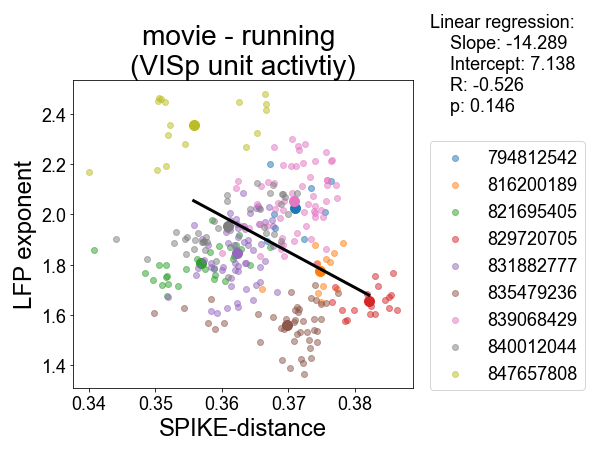

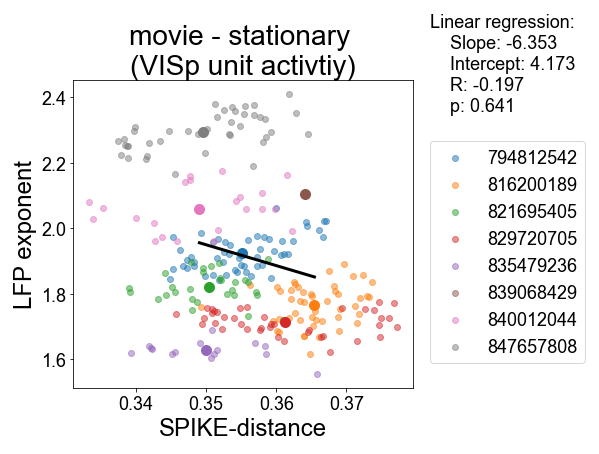

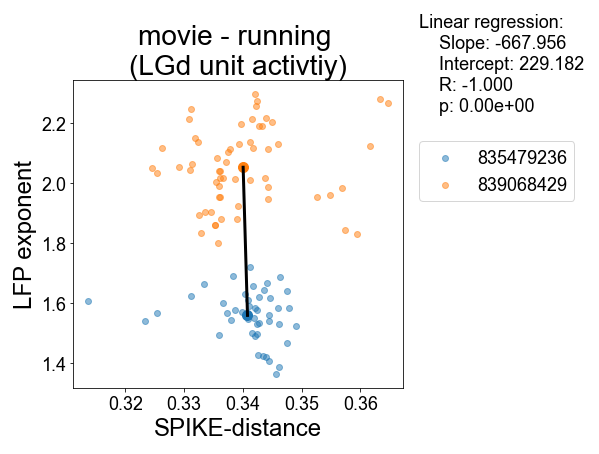

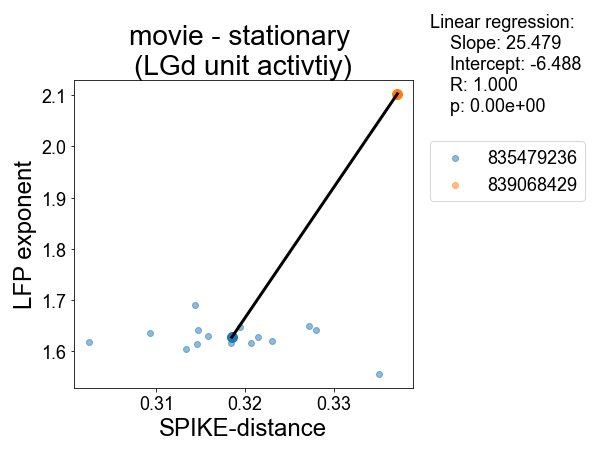

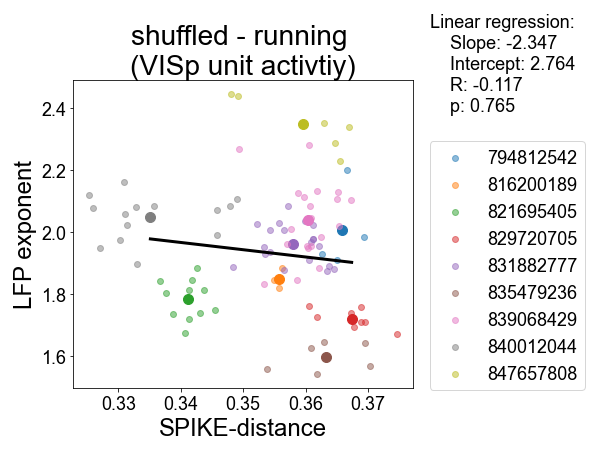

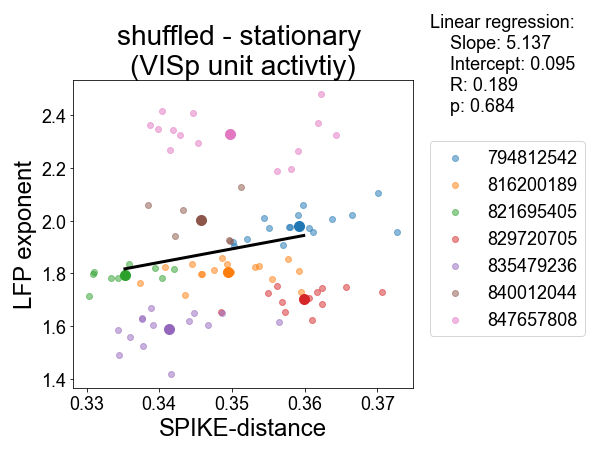

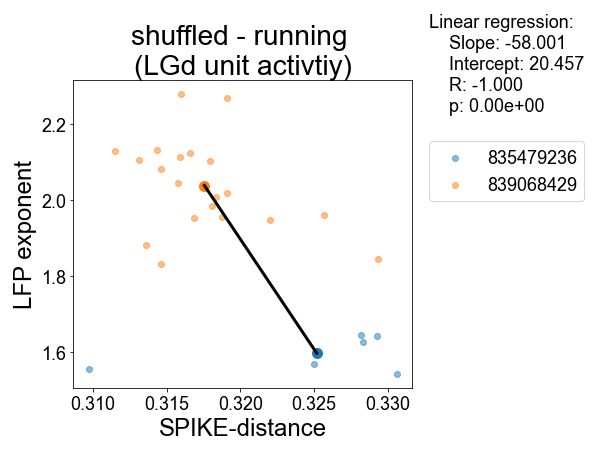

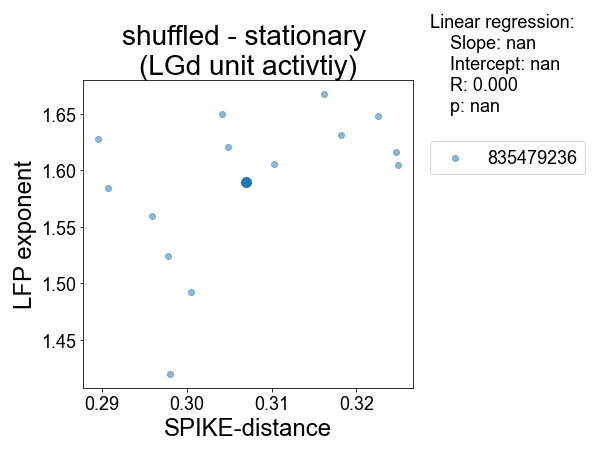

In [13]:
# loop through stimuli
for stimulus, df_lfp, df_units in zip(['movie', 'shuffled'], 
                                      [movie_lfp, shuffled_lfp],
                                      [movie_spikes, shuffled_spikes]):
    # modify df_lfp - average over channels for each epoch within each session
    df_lfp_i = df_lfp.groupby(['session', 'epoch_idx']).mean().reset_index()

    # loop through spiking region
    for spike_region in ['VISp', 'LGd']:
        # get unit data for this region
        df_units_i = df_units[df_units.get("brain_structure")==spike_region]  

        # merge unit and lfp dataframes
        df_i = df_lfp_i.merge(df_units_i, on=['session', 'epoch_idx'])

        # loop through behavioral conditions
        for behavior, running in zip(['running', 'stationary'], [True, False]):

            # filter df by behavior
            df = df_i[df_i.get('running')==running]

            # create figure
            fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
            fig.patch.set_facecolor('white')

            # plot each session
            sessions = df.get('session').unique()
            for ses in sessions:
                ses_df = df[df.get('session')==ses]

                # plot each epoch
                sc =  ax.scatter(ses_df.get('spike_distance'), 
                                 ses_df.get('exponent'), label=ses)

                # plot session mean
                ax.scatter(ses_df.get('spike_distance').mean(), 
                           ses_df.get('exponent').mean(), color=sc.get_facecolors()[0], s=100)
                sc.set_alpha(0.5)
                
            # run regression across all epochs and plot results
            df_avg = df.groupby(['session']).mean().reset_index()# average across trials
            x_data = df_avg.get('spike_distance')
            y_data = df_avg.get('exponent')
            results = sts.linregress(x_data, y_data)
            l1 = np.linspace(min(x_data), max(x_data), 1000)
            t1 = results.slope * l1 + results.intercept
            ax.plot(l1, t1, color='k', linewidth=3)

            # add regression results text
            if results.pvalue < 0.001:
                pval = f"{results.pvalue:.2e}"
            else:
                pval = f"{results.pvalue:.3f}"
            plt.text(1.05, 0.9, 
                    f"Linear regression:\n" +
                    f"    Slope: {results.slope:.3f}\n" +
                    f"    Intercept: {results.intercept:.3f}\n" +
                    f"    R: {results.rvalue:.3f}\n" +
                    f"    p: {pval}", transform = ax.transAxes)

            # label
            ax.legend(bbox_to_anchor=(1.05, .8), loc='upper left', borderaxespad=0.)
            plt.xlabel("SPIKE-distance")
            plt.ylabel("LFP exponent")
            plt.title(f"{stimulus} - {behavior} \n({spike_region} unit activtiy)")
            
            # save
            dir_figures = f"{PROJECT_PATH}/figures/exponent_vs_synchrony/{spike_region}/{behavior}"
            # plt.savefig(f"{dir_figures}/all_sessions")

### regression analysis - Spontaneous

In [ ]:
# look at parameter comparisons

# spike_sync vs. exponent graph + pearson R
# offset vs. firing rate

# SPLIT BASED ON BEHAVIOR

In [ ]:
# # nans for this session maybe missing lfp data in this last few epochs? (should be 44 below epochs), NOTE: session has nans in lfp

# e = params_df[params_df['session']==847657808]['epoch_idx'].unique()
# e

array([0, 1], dtype=int64)

In [ ]:
# # drop nans
# other_sessions = metric_df[(metric_df['session'] != 847657808)]
# nan_session = metric_df[(metric_df['session'] == 847657808) & (metric_df['epoch_idx'].isin(e[~np.isnan(e)]))]

# metric_df = pd.concat([other_sessions, nan_session])

In [ ]:
# get VISp spike data

# load spike stats
metric_fp = f'{PROJECT_PATH}/data/spike_data/synchrony_data/VISp-LGd_spontaneous.csv'
metric_df = pd.read_csv(metric_fp)

# get VISp rows
m = metric_df[metric_df['brain_structure']=='LGd']

# rename running column
m = m.rename(columns={'running':'behavior'})
m

,mean_firing_rate,unit_firing_rates,coefficient_of_variation,spike_distance,spike_synchrony,correlation_coefficient,epoch_times,epoch_idx,behavior,brain_structure,session
1070,12.500000,"[9.333333333333334, 27.1, 0.6, 19.1, 1.2666666...",0.929923,0.379266,0.268444,[[ 1. 0.32228183 0.20441508 -0.09387...,"[array(4404.24179622) * s, array(4434.24179622...",0,above,LGd,771160300
1071,11.305556,"[8.5, 26.433333333333334, 0.6333333333333333, ...",0.941368,0.380233,0.269877,[[ 1. 0.86139404 0.25162762 0.39157...,"[array(4501.96179622) * s, array(4531.96179622...",1,above,LGd,771160300
1072,12.166667,"[8.9, 28.533333333333335, 1.1333333333333333, ...",0.880546,0.383334,0.267397,[[ 1. -0.21853457 0.43396864 -0.13878...,"[array(4753.44179622) * s, array(4783.44179622...",2,above,LGd,771160300
1073,9.572222,"[5.233333333333333, 26.833333333333332, 0.2333...",0.838269,0.388584,0.225653,[[ 1. 0.44797727 0.2471309 -0.23107...,"[array(4783.44179622) * s, array(4813.44179622...",3,above,LGd,771160300
1074,11.344444,"[7.233333333333333, 28.866666666666667, 0.5666...",0.846249,0.396850,0.248972,[[ 1. 0.51753657 0.3124285 -0.35077...,"[array(4966.22179622) * s, array(4996.22179622...",4,above,LGd,771160300
...,...,...,...,...,...,...,...,...,...,...,...
1505,7.351852,"[1.6666666666666667, 7.866666666666666, 21.3, ...",1.057025,0.335776,0.176196,[[ 1. 0.32309325 0.23062856 -0.26305...,"[array(6077.75508127) * s, array(6107.75508127...",50,above,LGd,839068429
1506,7.085185,"[1.5, 8.366666666666667, 19.233333333333334, 8...",1.173945,0.341559,0.180214,[[ 1. 0.21083491 0.14402438 -0.08842...,"[array(6107.75508127) * s, array(6137.75508127...",51,above,LGd,839068429
1507,7.729630,"[1.9333333333333333, 9.266666666666667, 20.0, ...",1.083863,0.338730,0.181121,[[ 1. -0.03072749 -0.00749524 -0.23081...,"[array(6137.75508127) * s, array(6167.75508127...",52,above,LGd,839068429
1508,11.529630,"[7.1, 9.2, 22.7, 9.166666666666666, 11.9, 11.7...",1.035925,0.324067,0.255943,[[ 1. 0.20668745 0.03877156 -0.08130...,"[array(4589.91508127) * s, array(4619.91508127...",0,below,LGd,839068429


In [ ]:
# load LFP spectral params
params_r = pd.read_csv(f'{PROJECT_PATH}/data/lfp_data/params/psd/spontaneous_running/lfp_params.csv')
params_r['behavior'] = 'above'
params_s = pd.read_csv(f'{PROJECT_PATH}/data/lfp_data/params/psd/spontaneous_stationary/lfp_params.csv')
params_s['behavior'] = 'below'
params_df = pd.concat([params_r, params_s], axis=0)
params_df

,offset,knee,exponent,cf_0,pw_0,bw_0,cf_1,pw_1,bw_1,cf_2,...,bw_2,cf_3,pw_3,bw_3,error,r_squared,chan_idx,epoch_idx,session,behavior
0,-3.168223,5721.273695,2.660201,6.574948,0.797965,3.286142,55.222716,0.225969,20.000000,57.637887,...,2.000000,NaN,NaN,NaN,0.080482,0.983967,0,0,766640955,above
1,-3.024285,9864.018369,2.777015,6.282959,0.715921,4.520846,55.406936,0.263870,17.231366,57.649551,...,2.076471,NaN,NaN,NaN,0.075409,0.986572,1,0,766640955,above
2,-3.610363,2328.275483,2.495144,6.499553,0.705439,3.511096,54.901183,0.265729,20.000000,57.640961,...,2.217173,NaN,NaN,NaN,0.070402,0.987076,2,0,766640955,above
3,-3.233827,7878.621460,2.709611,6.160169,0.677050,5.003096,55.413892,0.298838,16.722095,57.643653,...,2.260894,NaN,NaN,NaN,0.072955,0.987016,3,0,766640955,above
4,-3.280067,6828.911425,2.680383,4.965001,0.648455,6.555850,55.583882,0.317543,14.971504,57.694849,...,2.020561,NaN,NaN,NaN,0.076737,0.985364,4,0,766640955,above
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15694,-4.140939,62.767245,2.201325,47.903149,0.230530,14.030602,55.085107,0.403565,5.336147,73.066667,...,20.000000,NaN,NaN,NaN,0.081320,0.984127,19,43,847657808,below
15695,-4.146110,79.297984,2.210673,47.903149,0.205539,13.620104,54.998220,0.397279,5.339615,73.066667,...,20.000000,NaN,NaN,NaN,0.081023,0.984035,20,43,847657808,below
15696,-4.417358,222.703090,2.186631,54.395734,0.309937,10.366985,68.706850,0.243746,4.759143,81.566667,...,20.000000,NaN,NaN,NaN,0.091509,0.975573,21,43,847657808,below
15697,-4.796245,128.927789,2.125712,50.800000,0.234069,10.791797,55.872209,0.432467,3.530060,72.366667,...,20.000000,NaN,NaN,NaN,0.095544,0.974394,22,43,847657808,below


In [ ]:
# compute median across LFP channels
p = params_df.groupby(['session','behavior','epoch_idx']).median().reset_index().drop(columns='chan_idx')
p['epoch_idx'] = p['epoch_idx'].apply(int)
p

,session,behavior,epoch_idx,offset,knee,exponent,cf_0,pw_0,bw_0,cf_1,pw_1,bw_1,cf_2,pw_2,bw_2,cf_3,pw_3,bw_3,error,r_squared
0,766640955,above,0,-4.192385,419.225126,2.153305,5.893883,0.611529,6.527537,55.650909,0.504315,7.624057,58.011452,0.526359,2.239034,177.973461,0.253721,11.000000,0.076054,0.981122
1,766640955,above,1,-3.944030,517.492268,2.251483,53.128235,0.642053,5.116870,56.515695,0.730831,4.088557,89.532428,0.369800,3.991414,130.133333,0.188439,20.000000,0.089444,0.970857
2,766640955,below,0,-4.267030,85.121061,2.100995,8.540408,0.295722,5.050464,55.704692,0.380327,4.725519,66.147045,0.237387,14.339789,108.103823,0.201063,20.000000,0.077856,0.984851
3,766640955,below,1,-4.039251,1096.553408,2.186750,5.116086,0.654455,5.571293,55.585929,0.509652,3.907560,57.916961,0.361139,20.000000,62.000000,0.269722,20.000000,0.077228,0.981066
4,766640955,below,2,-4.061158,458.159383,2.170427,4.324350,0.496756,5.714373,55.101286,0.648006,4.617157,80.421782,0.310874,3.225687,109.085838,0.355944,6.607616,0.074908,0.983556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958,847657808,below,39,-4.326277,13.336115,2.179008,43.163410,0.289092,11.501215,53.423941,0.378239,3.211702,62.356129,0.302283,9.624346,78.036445,0.206359,20.000000,0.072306,0.986664
959,847657808,below,40,-4.303945,62.267841,2.300853,5.673874,0.331404,5.526074,48.809294,0.326620,11.364304,58.166667,0.259239,20.000000,96.800000,0.204432,20.000000,0.077927,0.985786
960,847657808,below,41,-4.364184,25.779505,2.238651,45.166394,0.335272,4.050301,50.207587,0.302419,4.509900,55.925334,0.279149,12.471192,71.566667,0.179654,20.000000,0.076897,0.984789
961,847657808,below,42,-4.282136,365.036852,2.367738,4.051859,0.336404,7.113409,51.766667,0.328758,17.935552,58.488787,0.255920,20.000000,NaN,NaN,NaN,0.079534,0.982787


In [ ]:
# merge spike and LFP results
df = m.merge(p, on=['session','behavior','epoch_idx'])
df

,mean_firing_rate,unit_firing_rates,coefficient_of_variation,spike_distance,spike_synchrony,correlation_coefficient,epoch_times,epoch_idx,behavior,brain_structure,...,pw_1,bw_1,cf_2,pw_2,bw_2,cf_3,pw_3,bw_3,error,r_squared
0,12.500000,"[9.333333333333334, 27.1, 0.6, 19.1, 1.2666666...",0.929923,0.379266,0.268444,[[ 1. 0.32228183 0.20441508 -0.09387...,"[array(4404.24179622) * s, array(4434.24179622...",0,above,LGd,...,0.751543,2.889063,58.565245,0.655470,3.726612,61.433483,0.656562,6.059184,0.071229,0.980864
1,11.305556,"[8.5, 26.433333333333334, 0.6333333333333333, ...",0.941368,0.380233,0.269877,[[ 1. 0.86139404 0.25162762 0.39157...,"[array(4501.96179622) * s, array(4531.96179622...",1,above,LGd,...,0.439328,6.001572,113.975191,0.385101,2.713168,190.369266,0.436949,2.000000,0.074601,0.979330
2,12.166667,"[8.9, 28.533333333333335, 1.1333333333333333, ...",0.880546,0.383334,0.267397,[[ 1. -0.21853457 0.43396864 -0.13878...,"[array(4753.44179622) * s, array(4783.44179622...",2,above,LGd,...,0.418152,3.994520,59.916667,0.386045,20.000000,65.800000,0.297214,4.014720,0.083457,0.981257
3,9.572222,"[5.233333333333333, 26.833333333333332, 0.2333...",0.838269,0.388584,0.225653,[[ 1. 0.44797727 0.2471309 -0.23107...,"[array(4783.44179622) * s, array(4813.44179622...",3,above,LGd,...,0.710127,3.455877,57.402301,0.553575,4.169529,190.464838,0.597148,2.000000,0.076215,0.976895
4,11.344444,"[7.233333333333333, 28.866666666666667, 0.5666...",0.846249,0.396850,0.248972,[[ 1. 0.51753657 0.3124285 -0.35077...,"[array(4966.22179622) * s, array(4996.22179622...",4,above,LGd,...,0.374633,4.134704,57.019860,0.452035,6.127646,189.163955,0.479904,3.880706,0.069767,0.983115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,7.351852,"[1.6666666666666667, 7.866666666666666, 21.3, ...",1.057025,0.335776,0.176196,[[ 1. 0.32309325 0.23062856 -0.26305...,"[array(6077.75508127) * s, array(6107.75508127...",50,above,LGd,...,0.512654,2.033763,56.486674,0.316750,20.000000,59.279927,0.294171,20.000000,0.075552,0.979590
405,7.085185,"[1.5, 8.366666666666667, 19.233333333333334, 8...",1.173945,0.341559,0.180214,[[ 1. 0.21083491 0.14402438 -0.08842...,"[array(6107.75508127) * s, array(6137.75508127...",51,above,LGd,...,0.397141,2.004132,56.698009,0.281264,20.000000,62.400000,0.259881,20.000000,0.080508,0.978663
406,7.729630,"[1.9333333333333333, 9.266666666666667, 20.0, ...",1.083863,0.338730,0.181121,[[ 1. -0.03072749 -0.00749524 -0.23081...,"[array(6137.75508127) * s, array(6167.75508127...",52,above,LGd,...,0.386582,2.000000,60.016667,0.255204,20.000000,66.533333,0.236664,20.000000,0.073476,0.980791
407,11.529630,"[7.1, 9.2, 22.7, 9.166666666666666, 11.9, 11.7...",1.035925,0.324067,0.255943,[[ 1. 0.20668745 0.03877156 -0.08130...,"[array(4589.91508127) * s, array(4619.91508127...",0,below,LGd,...,0.288764,20.000000,56.159160,0.299743,5.168755,181.566667,0.211996,20.000000,0.073602,0.980543


In [ ]:
def linregress_plot(x, y):
    # imports
    from scipy.stats import linregress

    # remove NaN
    nan_items = np.logical_or(np.isnan(x), np.isnan(y))
    x = x[~nan_items]
    y = y[~nan_items]
    
    # set up plot
    fig, ax = plt.subplots(figsize=(16,12), constrained_layout=True)
    fig.patch.set_facecolor('white')
    
    # plot data
    sns.scatterplot(x=x, y=y)

    # run regression and plot results
    results = linregress(x, y)
    t_lin = np.linspace(np.nanmin(x), np.nanmax(x), 100)
    lin = results.slope * t_lin + results.intercept
    ax.plot(t_lin, lin, color='r')

    # add regression results text
    if results.pvalue < 0.001:
        pval = f"{results.pvalue:.2e}"
    else:
        pval = f"{results.pvalue:.3f}"
    plt.text(1.05, 0.9, 
             f"Regression:\n" +
             f"    Slope: {results.slope:.3f}\n" +
             f"    Intercept: {results.intercept:.3f}\n" +
             f"    R: {results.rvalue:.3f}\n" +
             f"    p: {pval}", transform = ax.transAxes, fontsize=15)
    
    return results

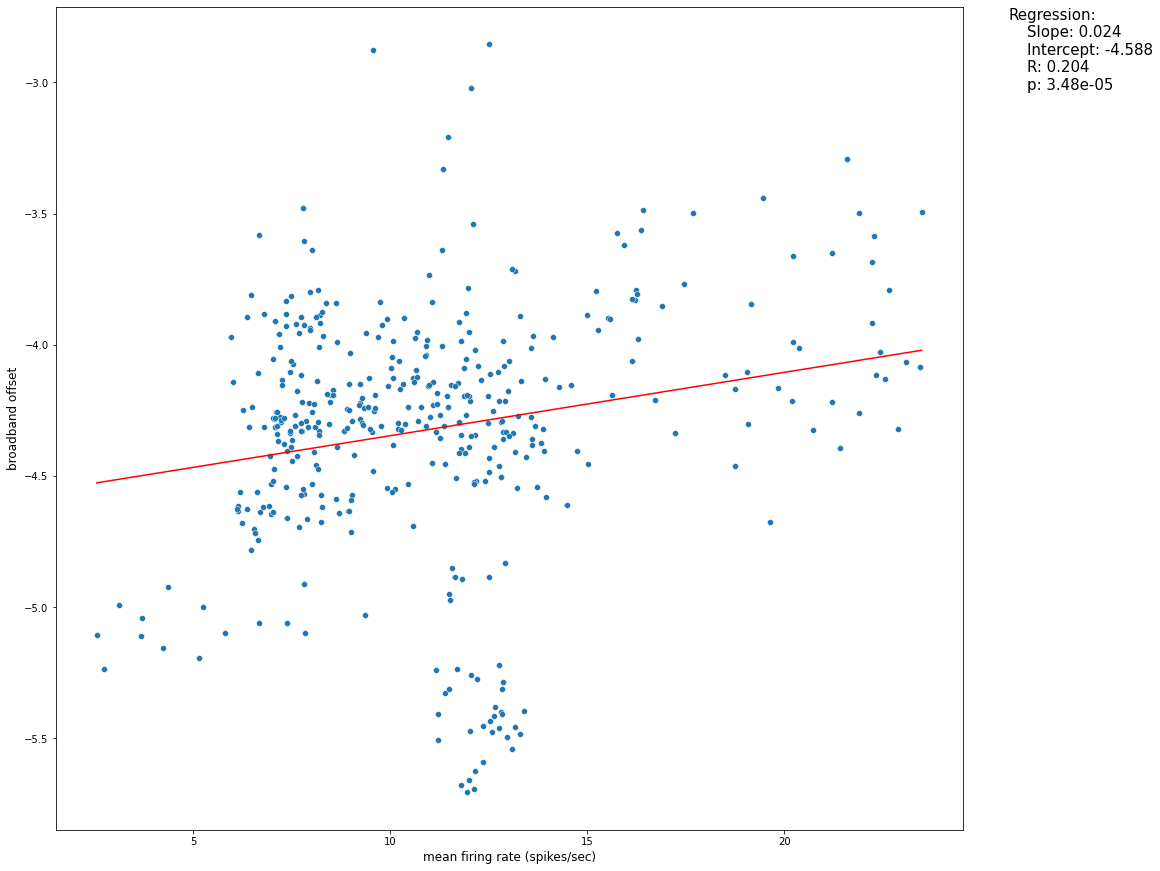

In [ ]:
# plot offset v rate

results = linregress_plot(x=df['mean_firing_rate'], y=df['offset'])
plt.xlabel('mean firing rate (spikes/sec)')
plt.ylabel('broadband offset');

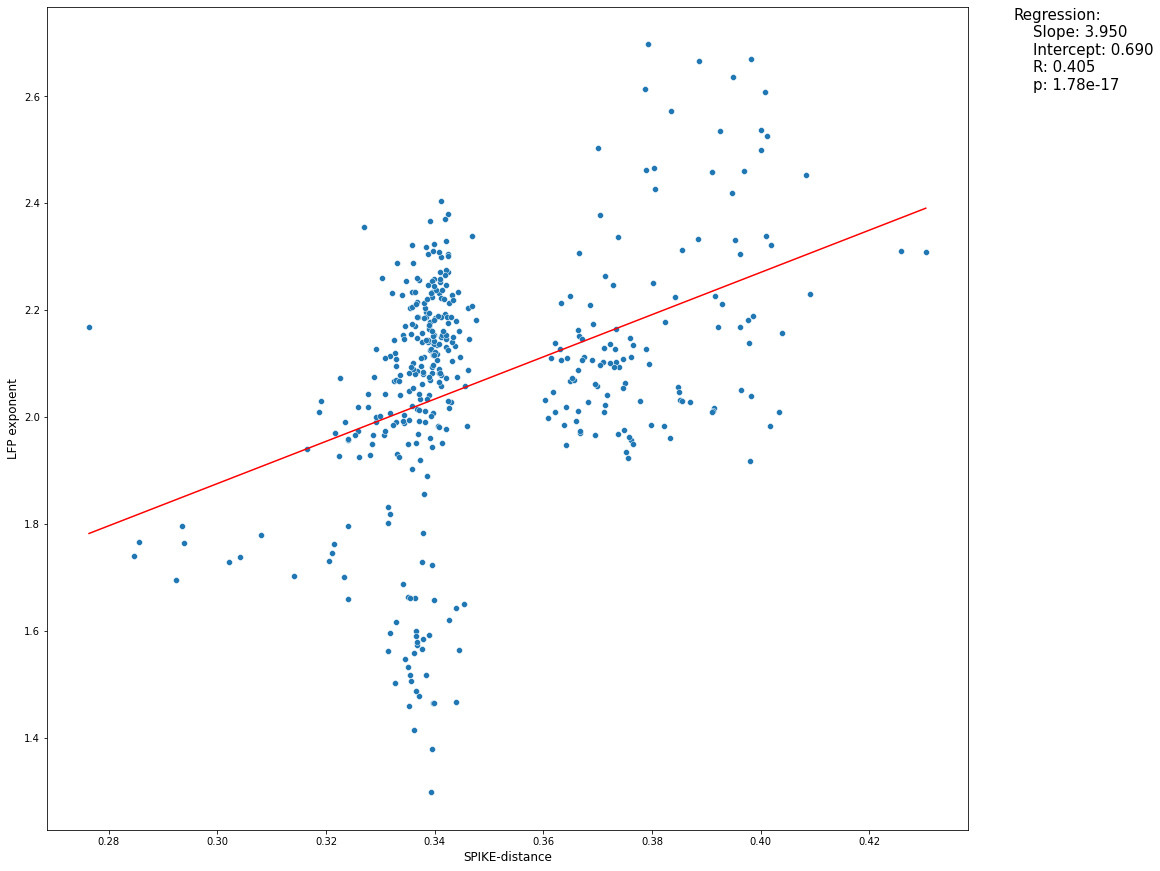

In [ ]:
# plot exponent v synchrony

results = linregress_plot(x=df['spike_distance'], y=df['exponent'])
plt.xlabel('SPIKE-distance')
plt.ylabel('LFP exponent');

In [ ]:
# # remove outliers and plot
# no_outlier_df = df[df['spike_distance'] > 0.25]

# linregressplot(x=no_outlier_df['spike_distance'], y=no_outlier_df['exponent'])
# plt.xlabel('SPIKE-distance')
# plt.ylabel('LFP exponent');

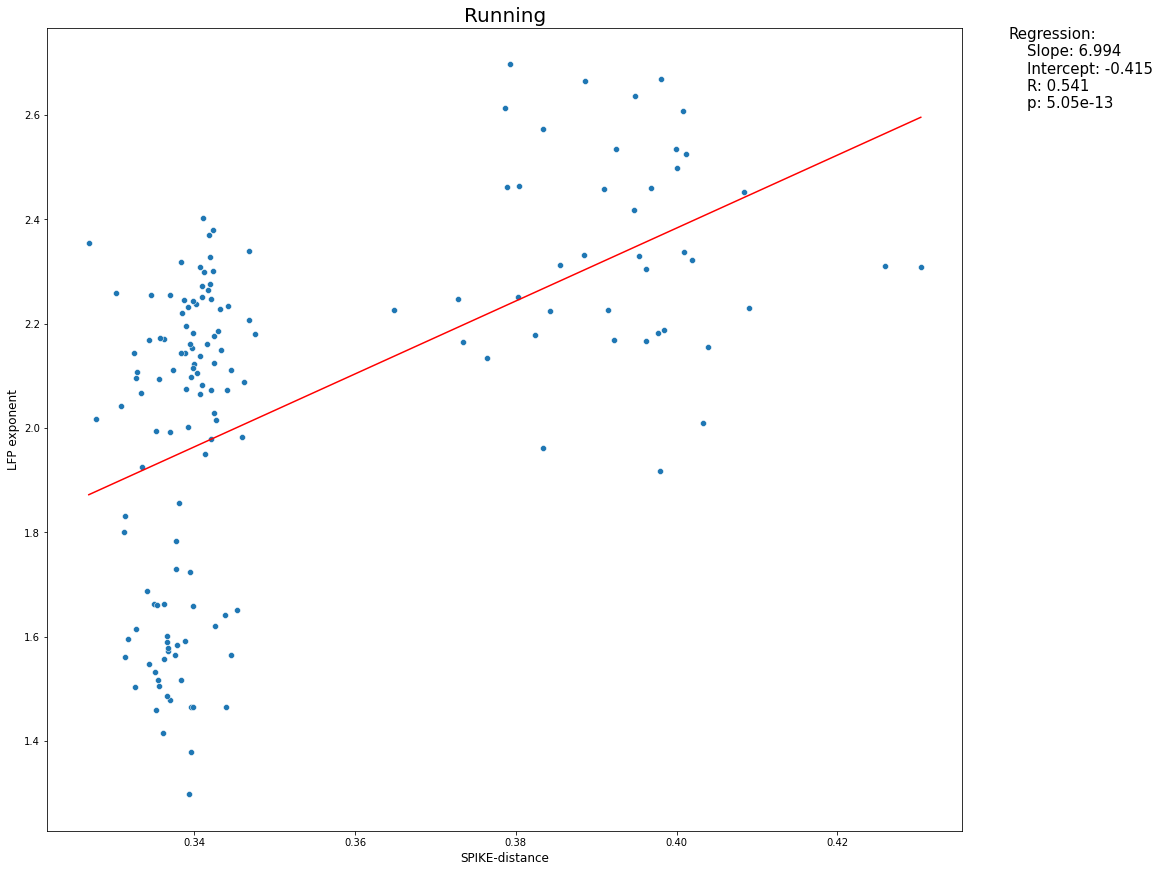

In [ ]:
# repeat for running epochs only
behav_df = df.loc[df['behavior'] == 'above']

results = linregress_plot(x=behav_df['spike_distance'], y=behav_df['exponent'])
plt.xlabel('SPIKE-distance')
plt.ylabel('LFP exponent')
plt.title('Running');

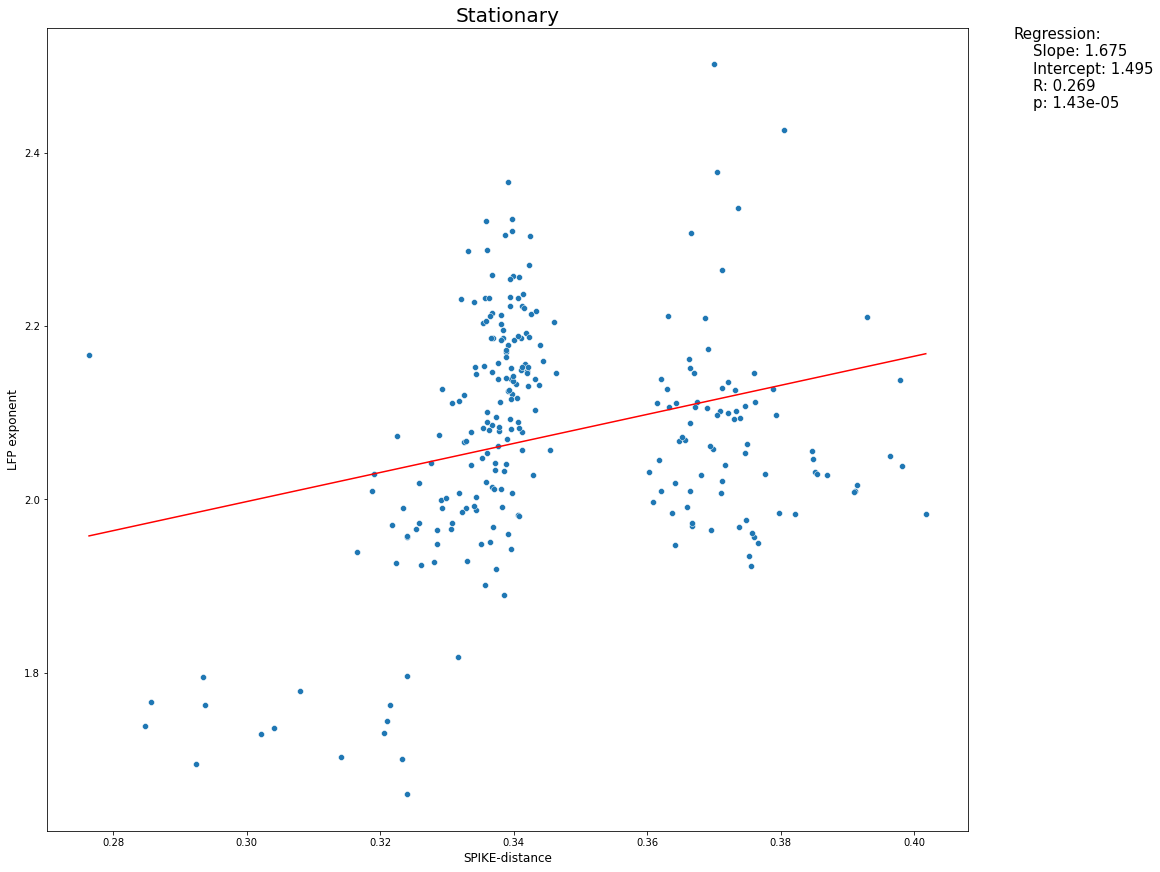

In [ ]:
# repeat for stationary epochs only

behav_df = df[df['behavior'] == 'below']

results = linregress_plot(x=behav_df['spike_distance'], y=behav_df['exponent'])
plt.xlabel('SPIKE-distance')
plt.ylabel('LFP exponent')
plt.title('Stationary');